In [20]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [21]:
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [22]:
chars = sorted(set(''.join(words)))
s_to_i = {s:i+1 for i,s in enumerate(chars)}
s_to_i['.'] = 0
i_to_s = {i+1:s for i,s in enumerate(chars)}
i_to_s[0] = '.'
vocab_size = len(i_to_s)
print(vocab_size)

27


In [23]:
import random
random.seed(42)
random.shuffle(words)

In [24]:
#build the dataset

block_size = 3 #context length

def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for c in w + '.':
            ix = s_to_i[c]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X,Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

X_train, Y_train = build_dataset(words[:n1])
X_val, Y_val = build_dataset(words[n1:n2])
X_test, Y_test = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [25]:
for x,y in zip(X_train[:20], Y_train[:20]):
    print(''.join(i_to_s[ix.item()] for ix in x), '-->', i_to_s[y.item()])

... --> y
..y --> u
.yu --> h
yuh --> e
uhe --> n
hen --> g
eng --> .
... --> d
..d --> i
.di --> o
dio --> n
ion --> d
ond --> r
ndr --> e
dre --> .
... --> x
..x --> a
.xa --> v
xav --> i
avi --> e


In [33]:
class Linear:

    def __init__(self, fan_in, fan_out, bias=True): #fan_in is the number of input features
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    

class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum = 0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        #params trained with backprop
        self.gamma = torch.ones(dim) #bn_gain above
        self.beta = torch.zeros(dim) #bn_bias above
        #buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self,x):
        #calculate forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) #batch mean
            xvar = x.var(0, keepdim=True) #batch var
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) #mormalize to unit variance
        self.out = self.gamma*xhat + self.beta #h_pre_act above
        #update buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1-self.momentum)*self.running_mean + self.momentum*xmean
                self.running_var = (1-self.momentum)*self.running_var + self.momentum*xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    

class Tanh:

    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []
    
class Embedding:

    def __init__(self, num_embeds, embed_dim):
        self.weight = torch.randn((num_embeds, embed_dim))
    
    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out
    
    def parameters(self):
        return [self.weight]
    
class Flatten:

    def __call__(self, x):
        self.out = x.view(x.shape[0], -1)
        return self.out
    
    def parameters(self):
        return []
    
class Sequential:

    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    
    def paramters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [27]:
torch.manual_seed(42)

In [34]:
n_embd = 10
n_hidden = 200

model = Sequential([
    Embedding(vocab_size, n_embd),
    Flatten(),
    Linear(n_embd*block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

with torch.no_grad():
    model.layers[-1].weight *= 0.1 #make the last layer less confident because we want the logits to be small afte the first iteration

parameters = model.paramters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

12097


In [35]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    #minibatch creation
    ix = torch.randint(0, X_train.shape[0], (batch_size,))
    Xb, Yb = X_train[ix], Y_train[ix]

    #forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)

    #backward pass
    # for layer in layers:
    #     layer.out.retain_grad() #after debug: remove this line
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    lr = 0.1 if i < 150000 else 0.01
    for p in parameters:
        p.data -= lr * p.grad
    
    #track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10())

    # if i >= 1000:
    #     break #after debug: remove this line

      0/ 200000: 3.3008
  10000/ 200000: 2.2598
  20000/ 200000: 2.2396
  30000/ 200000: 2.0144
  40000/ 200000: 2.1231
  50000/ 200000: 2.4112
  60000/ 200000: 2.1439
  70000/ 200000: 2.3683
  80000/ 200000: 1.8852
  90000/ 200000: 2.5812
 100000/ 200000: 2.3047
 110000/ 200000: 2.3619
 120000/ 200000: 1.9074
 130000/ 200000: 2.1133
 140000/ 200000: 2.2957
 150000/ 200000: 2.3872
 160000/ 200000: 1.9970
 170000/ 200000: 2.0397
 180000/ 200000: 1.9228
 190000/ 200000: 2.2137


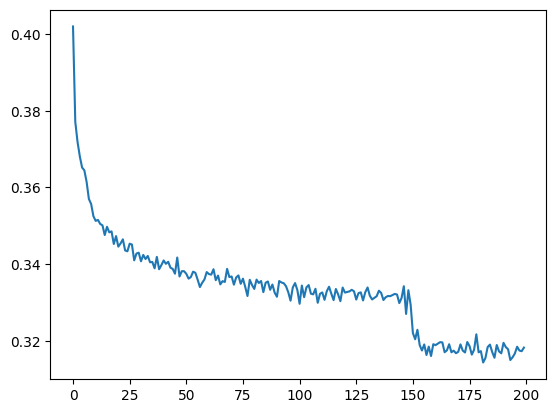

In [36]:
plt.plot(torch.tensor(lossi).view(-1,1000).mean(1))

In [37]:
#put layers into eval mode (needed mainly for batchnorm) cuz they are in training = True
for layer in model.layers:
    layer.training = False

In [38]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (X_train, Y_train),
    'val': (X_val, Y_val),
    'test': (X_test, Y_test),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0570077896118164
val 2.10304594039917


In [39]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      logits = model(torch.tensor([context]))
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(i_to_s[i] for i in out)) # decode and print the generated word

carlah.
amelle.
khyimra.
reviyah.
cassie.
rahnee.
delynn.
jarqui.
nellara.
chaiiv.
kaleigh.
ham.
jock.
quintis.
lilea.
jamilio.
jerogiearyxi.
jace.
pirra.
med.
